In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import LeaveOneOut, StratifiedKFold
from sklearn.model_selection._split import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectPercentile

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

import qgrid

from collections import Counter
from pprint import pprint

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [4]:
data = pd.read_csv('/Users/alex.sliz-nagy/work/egyetem/train.csv')
train, test = train_test_split(data, train_size=0.8)
print(len(train), len(test))

712 179


In [22]:
train = train.copy(deep=True)
test = test.copy(deep=True)

## Data information

**Variable**	Definition	Key<br/>
**survival**	Survival	0 = No, 1 = Yes <br/>
**pclass**	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd <br/>
**sex**	Sex <br/>
**Age**	Age in years <br/>
**sibsp**	# of siblings / spouses aboard the Titanic <br/>
**parch**	# of parents / children aboard the Titanic <br/>
**ticket**	Ticket number <br/>
**fare**	Passenger fare <br/>
**cabin**	Cabin number <br/>
**embarked**	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton<br/>
<br/>
<br/>
pclass: A proxy for socio-economic status (SES)<br/>
1st = Upper<br/>
2nd = Middle<br/>
3rd = Lower<br/>
<br/>
age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5<br/>
<br/>
sibsp: The dataset defines family relations in this way...<br/>
Sibling = brother, sister, stepbrother, stepsister<br/>
Spouse = husband, wife (mistresses and fiancés were ignored)<br/>
<br/>
parch: The dataset defines family relations in this way...<br/>
Parent = mother, father<br/>
Child = daughter, son, stepdaughter, stepson<br/>
Some children travelled only with a nanny, therefore parch=0 for them.<br/>

# Pandas

In [5]:
train.head()

PassengerId  Survived  Pclass  \
39            40         1       3   
710          711         1       1   
662          663         0       1   
616          617         0       3   
400          401         1       3   

                                                 Name     Sex   Age  SibSp  \
39                        Nicola-Yarred, Miss. Jamila  female  14.0      1   
710  Mayne, Mlle. Berthe Antonine ("Mrs de Villiers")  female  24.0      0   
662                        Colley, Mr. Edward Pomeroy    male  47.0      0   
616                         Danbom, Mr. Ernst Gilbert    male  34.0      1   
400                                Niskanen, Mr. Juha    male  39.0      0   

     Parch             Ticket     Fare Cabin Embarked  
39       0               2651  11.2417   NaN        C  
710      0           PC 17482  49.5042   C90        C  
662      0               5727  25.5875   E58        S  
616      1             347080  14.4000   NaN        S  
400      0  STON/O 2. 3101289   7.9250   NaN        S

In [6]:
qgrid.show_grid(train.head(30))

In [7]:
qgrid.show_grid(train.describe())

In [8]:
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            129
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          543
Embarked         1
dtype: int64


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 39 to 63
Data columns (total 12 columns):
PassengerId    712 non-null int64
Survived       712 non-null int64
Pclass         712 non-null int64
Name           712 non-null object
Sex            712 non-null object
Age            583 non-null float64
SibSp          712 non-null int64
Parch          712 non-null int64
Ticket         712 non-null object
Fare           712 non-null float64
Cabin          169 non-null object
Embarked       711 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [11]:
# qgrid.show_grid(train[train.Pclass>=2].head(30))
Counter(train[train.Pclass>=2].Sex)

Counter({'female': 165, 'male': 362})

In [13]:
Counter(train[(train.Pclass>=2)&(train.Survived==1)].Sex)

Counter({'female': 105, 'male': 51})

# Visualization

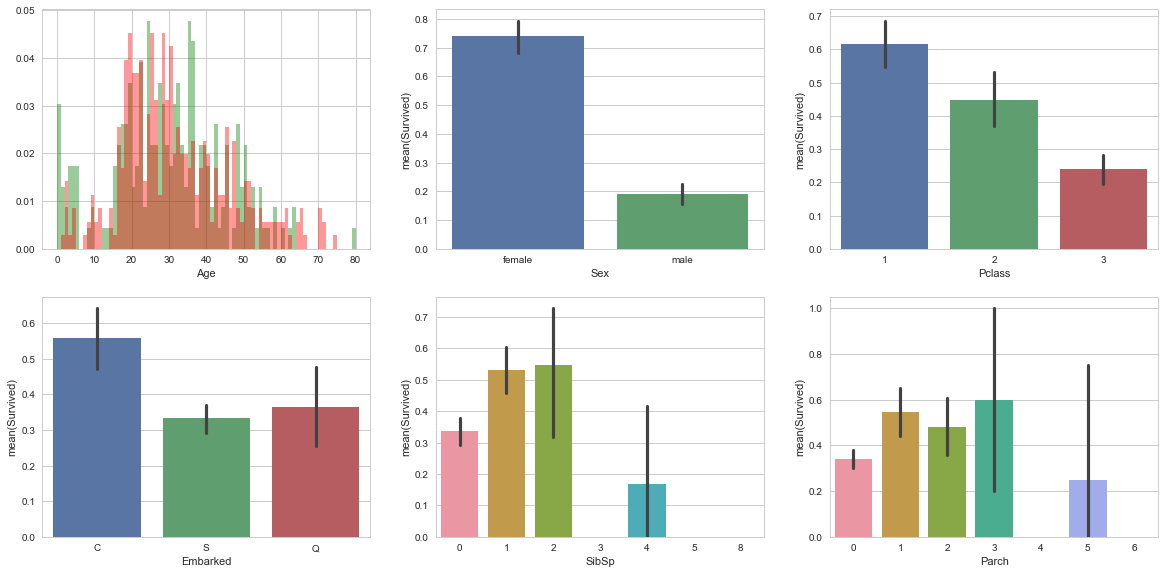

In [14]:
surv = train[train.Survived==1].copy(deep=True)
nosurv = train[train.Survived==0].copy(deep=True)

surv_col = 'green'
nosurv_col= 'red'

plt.figure(figsize=[20,15])
plt.subplot(331)
sns.distplot(surv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col, norm_hist=True)
sns.distplot(nosurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col, axlabel='Age', 
             norm_hist=True)
plt.subplot(332)
sns.barplot('Sex', 'Survived', data=train)
plt.subplot(333)
sns.barplot('Pclass', 'Survived', data=train)
plt.subplot(334)
sns.barplot('Embarked', 'Survived', data=train)
plt.subplot(335)
sns.barplot('SibSp', 'Survived', data=train)
plt.subplot(336)
sns.barplot('Parch', 'Survived', data=train)
# plt.subplot(337)
# sns.distplot(np.log10(surv['Fare'].dropna().values+1), kde=False, color=surv_col)
# sns.distplot(np.log10(nosurv['Fare'].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)


# Scikit-Learn

In [15]:
model = SGDClassifier(random_state=2)

In [16]:
v = CountVectorizer()
v = v.fit(train.Sex)
X = v.transform(train.Sex)

In [17]:
type(X)

scipy.sparse.csr.csr_matrix

In [18]:
model = model.fit(X, train.Survived)

In [19]:
test_x = v.transform(test.Sex)
p = model.predict(test_x)

In [20]:
print(accuracy_score(y_true=test.Survived.tolist(), y_pred=p))
print(classification_report(y_true=test.Survived.tolist(), y_pred=p))

0.793296089385
             precision    recall  f1-score   support

          0       0.82      0.83      0.83       107
          1       0.75      0.74      0.74        72

avg / total       0.79      0.79      0.79       179



In [23]:
test['pred'] = p
for s, d in test.groupby('Sex'):
    print(s, str(Counter(d.pred)))

female Counter({1: 71})
male Counter({0: 108})


In [40]:
Counter(test[test.Survived==1].Sex)

Counter({'female': 53, 'male': 19})

# Pipelines

### Basic pipeline

In [24]:
pipe = Pipeline([
    ('vec', CountVectorizer()),
    ('model', SGDClassifier(random_state=2))
])

In [25]:
pipe = pipe.fit(train.Sex, train.Survived)

In [26]:
test['pred'] = pipe.predict(test.Sex)

print('accuracy', accuracy_score(y_true=test.Survived.tolist(), y_pred=test.pred.tolist()))
print(classification_report(y_true=test.Survived.tolist(), y_pred=test.pred.tolist()))

accuracy 0.793296089385
             precision    recall  f1-score   support

          0       0.82      0.83      0.83       107
          1       0.75      0.74      0.74        72

avg / total       0.79      0.79      0.79       179



### Advanced pipelines

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """
    Selects a column form a 2D array.
    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return list(data_dict[self.key])

    

class Vectorizer(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [[x] for x in data] 

In [37]:
pipe = Pipeline([
    ('features', FeatureUnion([
        ('pclass_f', Pipeline([
            ('pclass_sel', ItemSelector(key='Pclass')),
            ('pclass_vec', Vectorizer())
        ])),
        ('sex_f', Pipeline([
            ('sex_sel', ItemSelector(key='Sex')),
            ('sex_vec', CountVectorizer())
        ])),
        ('age_f', Pipeline([
            ('age_sel', ItemSelector(key='Age_2')),
            ('pclass_vec', Vectorizer())
        ])),
        ('sib', Pipeline([
            ('sib_sel', ItemSelector(key='SibSp')),
            ('sib_vec', Vectorizer())
        ])),        
        ('parch', Pipeline([
            ('parch_sel', ItemSelector(key='Parch')),
            ('parch_vec', Vectorizer())
        ]))
    ])),
#     ('pclass_sel', ItemSelector(key='Pclass')),
#     ('model', SGDClassifier(random_state=0))
    ('model', SVC(kernel='rbf'))
#     ('model', RandomForestClassifier())
])

In [38]:
pipe = pipe.fit(train, train.Survived.tolist())

In [39]:
test['pred'] = pipe.predict(test)

print('accuracy', accuracy_score(y_true=test.Survived.tolist(), y_pred=test.pred.tolist()))
print(classification_report(y_true=test.Survived.tolist(), y_pred=test.pred.tolist()))

accuracy 0.810055865922
             precision    recall  f1-score   support

          0       0.81      0.90      0.85       107
          1       0.82      0.68      0.74        72

avg / total       0.81      0.81      0.81       179



## some more usefull stuff

In [33]:
avg_age = int(np.average(train[train.Age==train.Age].Age))

# f = lambda x: x if x == x else avg_age

train['Age_2'] = train.Age.apply(f)

# f = lambda x: x if x == x else avg_age
# train['Age_2'] = train.Age.apply(f)

In [34]:
test['Age_2'] = test.Age.apply(f)